In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pjr import *
import string
from timeit import default_timer as timer
from pprint import pprint
import cartopy.crs as ccrs

pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def getfld (fspec, vname, levs=None):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1)            # extract fields, remove dimensions length one

    if not levs is None:
        print "interpolate to pressure levels", levs
        ps = fspec('PS',squeeze=1)
        hyam = fspec('hyam',squeeze=1)
        hybm = fspec('hybm',squeeze=1)

        start = timer()
        P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
        P = P/100.; P.units = "hPa"
        stop1 = timer()
        print  "reconstruct P time = ", stop1-start
        FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
        stop2 = timer()
        print "interp time", stop2-stop1

        F = FP1

    return F;


def getdat (g0, vnameo, g1, g2, vname):
    """function to get model and obs datasets, move them to a common pressure coord grid, zonal average,
    returns:
        the observations (TP0xav)
        difference of model1 and obs (DT1xav)
        difference of model2 and obs (DT2xav)
    """
    T0 =  g0(vnameo,squeeze=1)            # get obs
    TM0 = g2(vname,squeeze=1) # get a model grid so we can do horizontal regrid obs
    T0 = T0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid

    T1 = getfld (g1, vname)


    T2 = getfld (g2, vname)


    DT2 = T2 - T0
    DT1 = T1 - T0

    return T0, DT1, DT2;


    
# a class that can hold model and observational names 
class vsets(object):
    def __init__(self, name=None, mname=None, oname=None, hash={}) :
         self.name = name
         self.mname = mname
         self.oname = oname

    

In [3]:
#----------------------------------------------------------
# define the metadata that controls the analysis and plotting
# identify the levels that we will interpolate to
levs = findNiceContours(np.array([1000.,10]),50,rmClev=0.) # in hPa
print "levs", levs
nlevs = cdms2.createAxis(levs) # make a cdms vertical grid to remap to

# the season to plot
seas = "ANN"
seas = "DJF"
seas = "JJA"

# observations
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980_2016_climo.nc'
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_'+seas+'_1980_2016_climo.nc'
ltit0 = "MERRA2"
print "jname0", jname0

# model1 dataset
dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_"+seas+"_climo.nc"
ltit1 = "CAM5-MERRA2"
jname1 = dir1+f1
print "jname1", jname1

# model2 dataset
dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_ANN_197912_200411_climo.nc'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_'+seas+'_climo.nc'
ltit2 = "EAMV1-MERRA2"
jname2 = dir2+f2
print "jname2", jname2  

# a list of variables and the names they are called in the model and obs dataset files
vlist = [] #create an empty list
vlist.append(vsets("Surface Air Temperature", "TREFHT","tas"))
#vlist.append(vsets("Surface Temperature", "T", "tsrf"))
#vlist.append(vsets("", "U", "ua"))


levs [  20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.
  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.
  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.
  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.
  980. 1000.]
jname0 /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_JJA_1980_2016_climo.nc
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_JJA_climo.nc
jname2 /global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/20180316.DECKv1b_A1.ne30_oEC.edison_JJA_climo.nc


In [4]:
from matplotlib import gridspec
def setup3 ():
    fig = plt.figure(figsize=(6, 9)) 
    gs = gridspec.GridSpec(3, 2, width_ratios=[20, 1]) 
    ax0 = plt.subplot(gs[0],projection=ccrs.Robinson())
    ax0.set_global() # make axis consistent with projection limits
    cx0 = plt.subplot(gs[1])
    ax1 = plt.subplot(gs[2],projection=ccrs.Robinson())
    ax1.set_global() # make axis consistent with projection limits
    cx1 = plt.subplot(gs[3])
    ax2 = plt.subplot(gs[4],projection=ccrs.Robinson())
    ax2.set_global() # make axis consistent with projection limits
    cx2 = plt.subplot(gs[5])
    return fig,[ax0,ax1,ax2],[cx0,cx1,cx2];

def defset (data, plotOpt, attribute):
    """return a sensible attribute
    if data is a numpy array, the default is an empty string
    if data is a smarter object like a cdms var it looks for an attribute
        if present that becomes the default
        else default is empty string
    if plotOpt dictionary contains a value, that is the returned quantity
    """
#    print "defset searching for ", attribute
    if hasattr(data,attribute):
        defval = getattr(data,attribute)
#        print attribute, "present, defval set to", defval
        #    variance.units = '(%s)^2'%var.units
    else:
#        print "no attribute defval set empty"
        defval = None
    val = plotOpt.get(attribute,defval)
#    print "defset returning", val
    return val;





obs varlist ['va', 'rsds', 'tas', 'rsdscs', 'zg', 'hfss', 'lon_bnds', 'height', 'rlutcs', 'prw', 'hfls', 'pr', 'rlut', 'climatology_bnds', 'rlus', 'rlds', 'vas', 'lat_bnds', 'uas', 'ta', 'psl', 'rsdt', 'hur', 'rsutcs', 'tauv', 'tauu', 'rsus', 'wap', 'ua', 'rsut']


NameError: name 'pltdat' is not defined

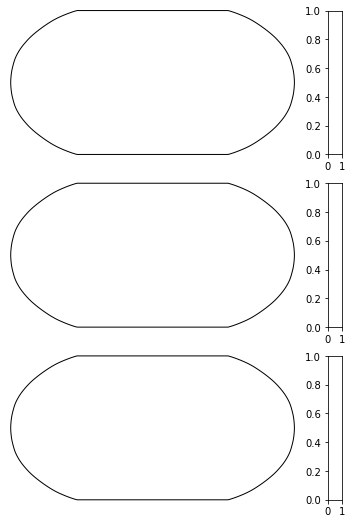

In [5]:

g0 = cdms2.open(jname0);
varlist = g0.listvariables();
print "obs varlist", varlist
dims = g0.listdimension();
g1 = cdms2.open(jname1);
g2 = cdms2.open(jname2)

fig, ax3, cx3 = setup3()
pltdat(TP0, DT1, DT2)
for i in vlist:
    break
    print "i", i.name
    pltname = "Moll_"+i.name+"_"+seas+"_MERRAvsModels.pdf"
    TP0, DT1, DT2 = getdat(g0, i.oname, g1, g2, i.mname)
    print pltname
    pltdat(TP0, DT1, DT2)
#    plt.savefig(pltname,type="pdf",bbox_inches='tight')
    #break
